<a href="https://colab.research.google.com/github/marinaD10/PRA3024/blob/main/Challenge2_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
# The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.
# 1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
# 2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt".
#    with the same parameters as above. Plot this waveform.
# 3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging
#    from 20 Hz up to the Nyquist frequency.
# 4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
# 5. What is the matched filter SNR of the signal?

In [3]:
# Loading the data
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
from gwpy.timeseries import TimeSeries
gwpy_data = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

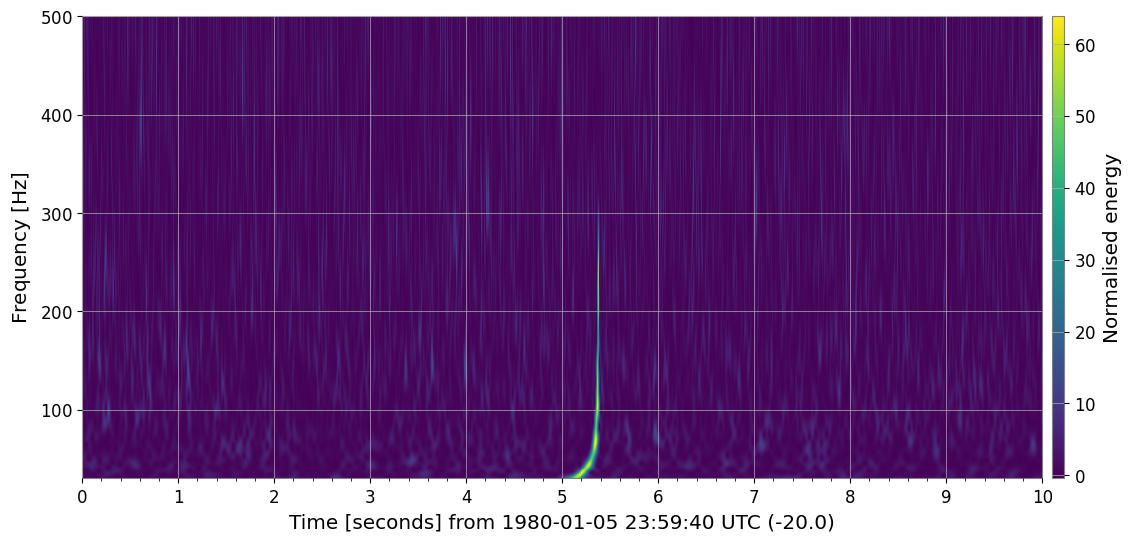

In [4]:
# Plotting a q-transform to determine the time of merger
qtransform = gwpy_data.q_transform(frange=(30, 500), qrange=(10, 300), outseg=(-20, -10))
plot = qtransform.plot()
plot.colorbar(label="Normalised energy")

##The approximate time of merger is between -15 and -14

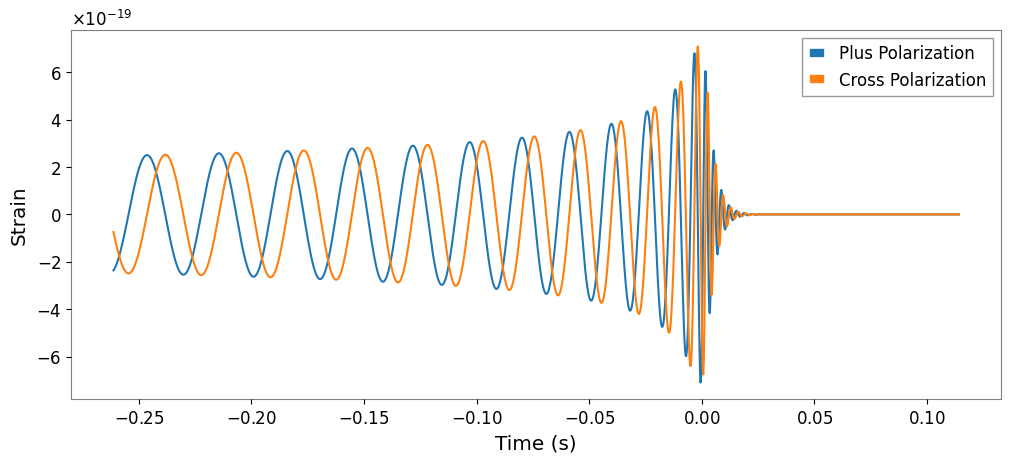

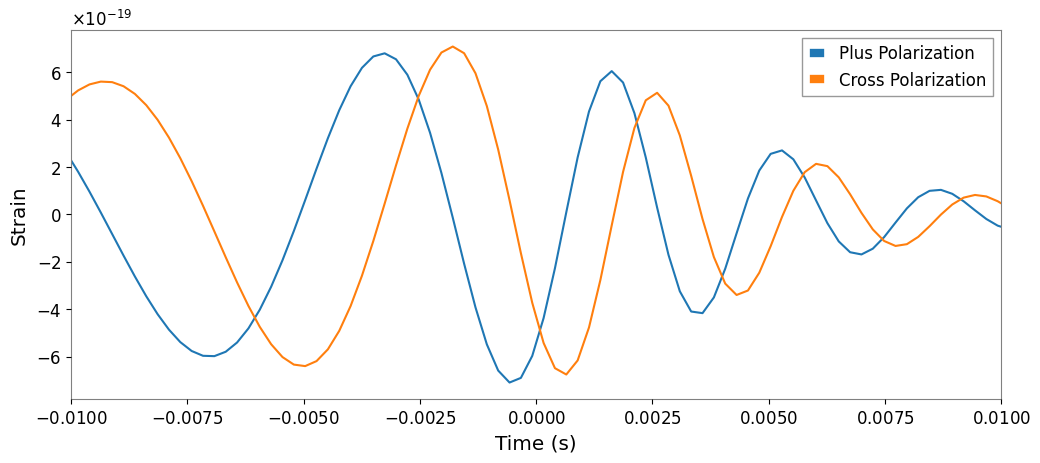

In [ ]:
# Plotting a time-domain template waveform using approximate "SEOBNRv4_opt"
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=0.00024414,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zooming near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

In [ ]:
# Finding the data's sample rate
gwpy_data.sample_rate

<Quantity 4096. Hz>

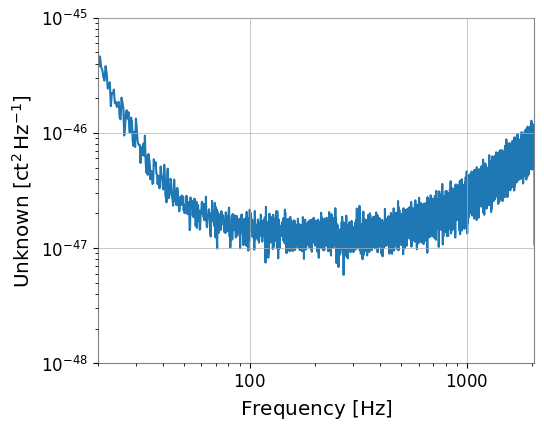

In [ ]:
# Calculating the PSD and plotting it on a log-log scale
psd= gwpy_data.psd(fftlength = 4 , overlap = 2, method ="median") # we use the method median because its averaging
plot = psd.plot(yscale='log', xscale='log')
ax = plot.gca()
ax.set_xlim(20,2048); # plotting from 20hz to the nyquist frequency, which is half the sampling rate
ax.set_ylim(1e-48,1e-45);

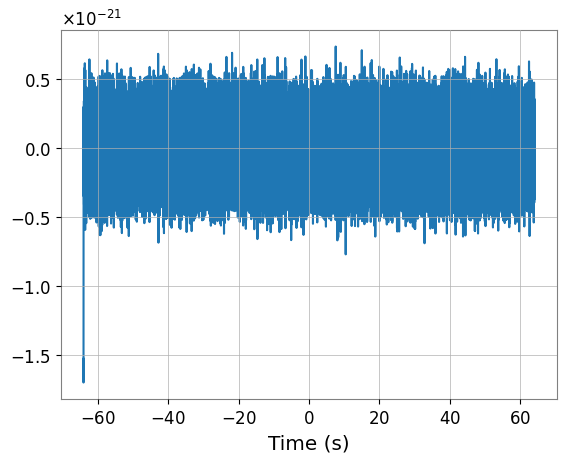

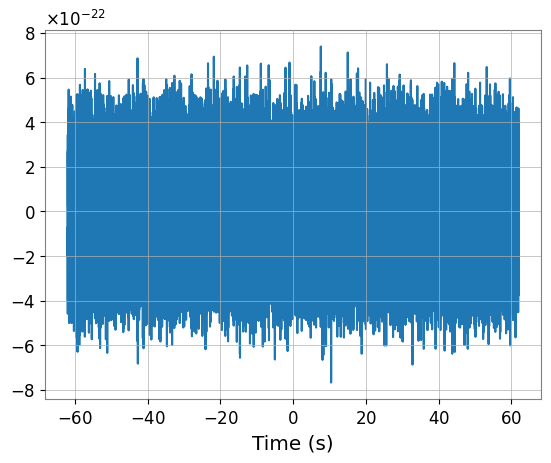

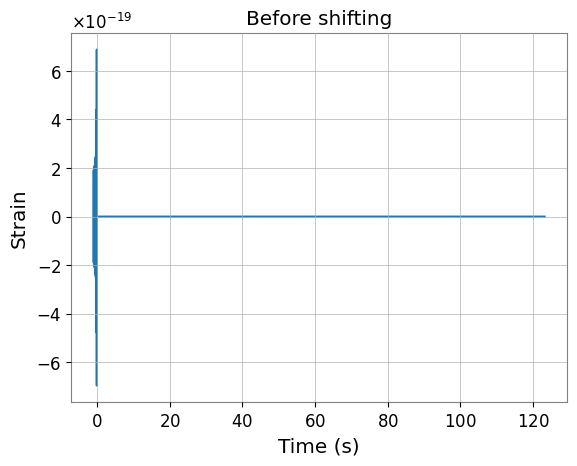

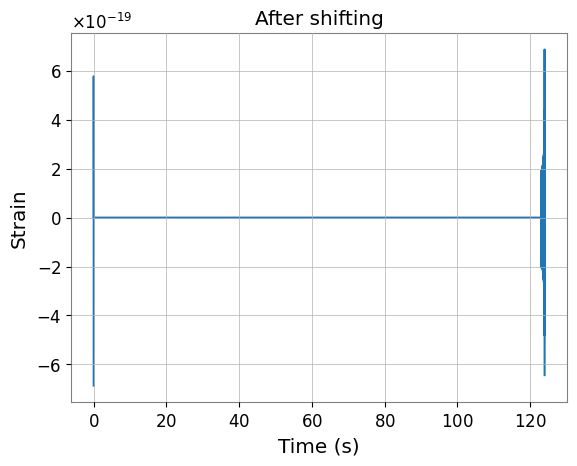

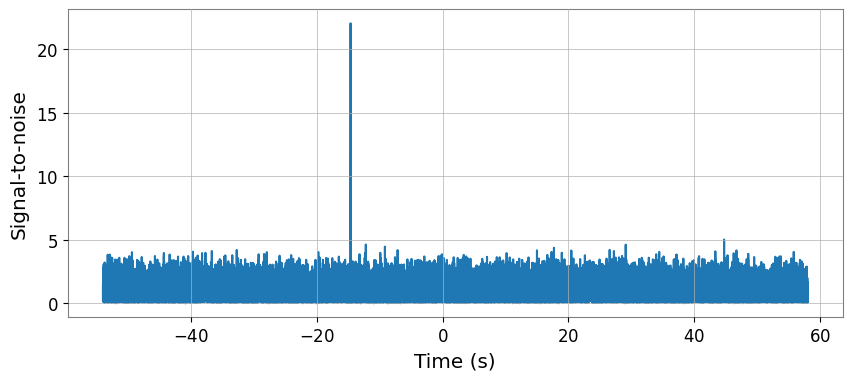

We found a signal at -14.6328125s with SNR 22.054545591712557


In [8]:
# Calculating the SNR time series and plotting the results
%matplotlib inline

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

strain = pycbc_strain

strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimating the power spectral density (PSD)

psd = conditioned.psd(4)

psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))

# Plotting the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

# Plotting the SNR time-series
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

In [ ]:
# The matched filter SNR of the signal is ∼22.0545 and we see that the time of merger -14.633